#Load Data

Files already downloaded and verified
Files already downloaded and verified
images-size: torch.Size([128, 3, 32, 32])
out-size: torch.Size([3, 546, 274])


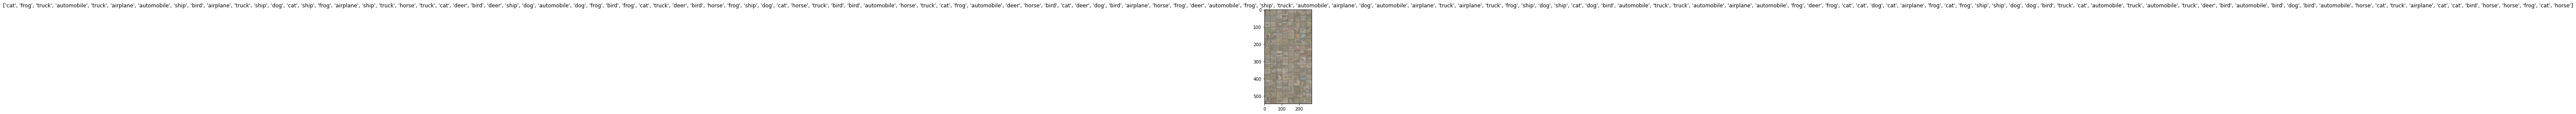

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision

from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import time
import copy
import os

from models import *
from utils import progress_bar

batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [2]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.counter = 0

# Training

In [3]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(train_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss


# Testing

In [4]:
def test(epoch,model_name):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(test_dataloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+model_name+'.pth')
        best_acc = acc
    return test_loss


In [5]:
classes = train_dataset.classes
lr = 0.1
n_epochs = 20

In [38]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = DenseNet121()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'DenseNet') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1


Epoch: 0
 [================================================================>]  Step: 144ms | Tot: 1m24s | Loss: 1.556 | Acc: 43.202% (21601/5000 391/391 1  
 [================================================================>]  Step: 15ms | Tot: 5s503ms | Loss: 1.188 | Acc: 57.610% (5761/1000 79/79 
Saving..

Epoch: 1
 [================================================================>]  Step: 146ms | Tot: 1m24s | Loss: 0.978 | Acc: 65.052% (32526/5000 391/391 1  
 [================================================================>]  Step: 15ms | Tot: 5s497ms | Loss: 1.128 | Acc: 60.190% (6019/1000 79/79 
Saving..

Epoch: 2
 [================================================================>]  Step: 144ms | Tot: 1m24s | Loss: 0.759 | Acc: 73.000% (36500/5000 391/391 1  
 [================================================================>]  Step: 15ms | Tot: 5s529ms | Loss: 0.818 | Acc: 71.580% (7158/1000 79/79 
Saving..

Epoch: 3
 [==========================================================

In [ ]:
del net

In [6]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = PreActResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'PreActResNet') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1



Epoch: 0
 [================================================================>]  Step: 52ms | Tot: 27s376ms | Loss: 1.793 | Acc: 34.174% (17087/5000 391/391 
 [================================================================>]  Step: 7ms | Tot: 2s643ms | Loss: 2.268 | Acc: 30.140% (3014/1000 79/79 
Saving..

Epoch: 1
 [================================================================>]  Step: 55ms | Tot: 27s309ms | Loss: 1.279 | Acc: 53.612% (26806/5000 391/391 
 [================================================================>]  Step: 6ms | Tot: 2s618ms | Loss: 1.136 | Acc: 59.170% (5917/1000 79/79 
Saving..

Epoch: 2
 [================================================================>]  Step: 57ms | Tot: 27s371ms | Loss: 0.973 | Acc: 65.556% (32778/5000 391/391 
 [================================================================>]  Step: 8ms | Tot: 2s633ms | Loss: 1.006 | Acc: 64.930% (6493/1000 79/79 =====>........................................................]  Step: 33ms | Tot: 340

In [ ]:
del net

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = DPN92()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'DPN') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1


Epoch: 0
 [================================================================>]  Step: 548ms | Tot: 5m32s | Loss: 3.009 | Acc: 13.404% (6702/5000 391/391 1 
 [================================================================>]  Step: 31ms | Tot: 19s163ms | Loss: 1.979 | Acc: 22.170% (2217/1000 79/79 
Saving..

Epoch: 1
 [================================================================>]  Step: 547ms | Tot: 5m32s | Loss: 1.825 | Acc: 29.862% (14931/5000 391/391 1 
 [================================================================>]  Step: 30ms | Tot: 19s163ms | Loss: 1.756 | Acc: 36.750% (3675/1000 79/79 
Saving..

Epoch: 2
 [================================================================>]  Step: 549ms | Tot: 5m32s | Loss: 1.491 | Acc: 44.192% (22096/5000 391/391 1 
 [================================================================>]  Step: 30ms | Tot: 19s172ms | Loss: 1.340 | Acc: 51.960% (5196/1000 79/79 
Saving..

Epoch: 3
 [===========================================================

In [ ]:
del net

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = EfficientNetB0()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'EffecientNet') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1

In [ ]:
del net

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = GoogLeNet()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'GoogleNet') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1

In [ ]:
del net

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = ResNeXt29_2x64d()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'ResNext') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1

In [ ]:
del net

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

net = DLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

epoch = 0
while(not(early_stopping.early_stop)):
    train_loss = train(epoch) / len(train_dataloader)
    validation_loss = test(epoch,'DLA') / len(test_dataloader)
    scheduler.step()
    early_stopping(train_loss,validation_loss)
    epoch+=1

In [ ]:
del net